In [1]:
# import packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import requests
from scipy.signal import find_peaks

In [2]:
file_path = './hohonu_key.txt'  # key file in same directory

try:
    with open(file_path, 'r') as file:
        key = file.read()
        print("API Key:", key)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

API Key: f20cc902a6ce182a35ffda595df9c171fba1e4ee


### Station Info

In [3]:
import requests

url = "https://dashboard.hohonu.io/api/v1/stations/node-10075"

headers = {
    "accept": "application/json",
    "Authorization": key
}

station_info = requests.get(url, headers=headers)

station_info.text

'{"id":"hohonu-118","station_type":"Hohonu","latitude":43.8943,"longitude":-69.8148,"status":"Active","local_mllw":"-4.863033710031814","download_permision":true,"subscribed":false,"distance":{"value":0.0,"unit":"meters"},"images":null,"access":true,"current_datum":"MLLW","datums":[{"value":"MLLW","label":"MLLW"},{"value":"MHHW","label":"MHHW"},{"value":"NAVD","label":"NAVD88"},{"value":"D2W_FEET","label":"Local Measure (feet)"},{"value":"D2W","label":"Local Measure (mm)"}],"station_id":"hohonu-118","uuid":"17044513-e846-4afc-9efc-56b5d2b4903f","organization":"GMRI","notes":"","location":"Maine Maritime Museum, Kennebec River, Bath, ME","installation_date":"2022-11-08T04:00:00Z","decommissioned_date":null,"nnoaa_station":"8418150","custom_nearest_noaa":null,"nearest_noaa_subordinate_observed":null,"nearest_noaa_subordinate_prediction":null,"d2w_begin_caution":null,"d2w_begin_emergency":null,"navd88_begin_caution":null,"navd88_begin_emergency":null,"mllw_begin_caution":null,"mllw_begin_

### Station Statistics

In [4]:
GMRIstations = {
    'Portland - GMRI Pier':'10038',
    'Portland - Back Cove':'10076',
    'Bath':'10075',
    'St. George - Southern Island':'10072',
    'Boothbay Harbor':'10214',
    'Chebeague Island':'10202',
    'Portland - Fore River':'10237',
    'St. George - Port Clyde':'10211',
    'Machias - Ultrasonic':'10203',
    'Machias - Radar':'12002'
    
}
                

### API Request for data - saves raw data as a CSV so turn this cell on for a new call

In [5]:
sensorID = GMRIstations['St. George - Southern Island']

#define start/end dates: set to 00:00Z for both dates (i.e. will include only one measurement on end date but this matches NOAA)
start_date = '2022-11-10'
end_date = '2023-10-10'


# cleaned data?
clean = 'false'

#NAVD88
url1 = "https://dashboard.hohonu.io/api/v1/stations/node-"+sensorID+"/statistic/?from="+start_date+"%2000%3A00&to="+end_date+"%2000%3A00&datum=navd&cleaned="+clean+"&tz=0&format=json"

#MLLW
url2 = "https://dashboard.hohonu.io/api/v1/stations/node-"+sensorID+"/statistic/?from="+start_date+"%2000%3A00&to="+end_date+"%2000%3A00&datum=mllw&cleaned="+clean+"&tz=0&format=json"

#D2W
url3 = "https://dashboard.hohonu.io/api/v1/stations/node-"+sensorID+"/statistic/?from="+start_date+"%2000%3A00&to="+end_date+"%2000%3A00&datum=d2w&cleaned="+clean+"&tz=0&format=json"

headers = {"Authorization": key}

response1 = requests.get(url1, headers=headers)
print(response1.status_code)
response2 = requests.get(url2, headers=headers)
print(response2.status_code)
response3 = requests.get(url3, headers=headers)
print(response3.status_code)

#########

df1 = response1.json()
df2 = response2.json()
df3 = response3.json()

# selecting individual time series from within the JSON dictionary
time = df1['data'][0]
htime = pd.DatetimeIndex(np.array(time)) # put Hohonu time values into an array with Datetime form

h_obs1 = df1['data'][1]
h_obs2 = df2['data'][1]
h_obs3 = df3['data'][1]

hobs1 = np.array(h_obs1, dtype = float)*0.3048 # put into an array and convert to metric
hobs2 = np.array(h_obs2, dtype = float)*0.3048
hobs3 = np.array(h_obs3, dtype = float)*0.001 # this comes in as mm -> convert to meters


data = {'date':time,'NAVD': hobs1, "MLLW": hobs2, "d2w": hobs3}
hohonu = pd.DataFrame(data=data)

hohonu.to_csv("StGeorgeSouthernIs_hohonu_raw.csv")

200
200
200


In [6]:
df = pd.read_csv("StGeorgeSouthernIs_hohonu_raw.csv") # Load in CSV
hobs1 = df.NAVD
hobs2 = df.MLLW
hobs3 = df.d2w
time = df.date

In [7]:
hdiff = hobs2-hobs1
print(hdiff)

0        1.240536
1        1.240536
2        1.240536
3        1.237488
4        1.237488
           ...   
79904    1.240536
79905    1.240536
79906    1.237488
79907    1.240536
79908         NaN
Length: 79909, dtype: float64


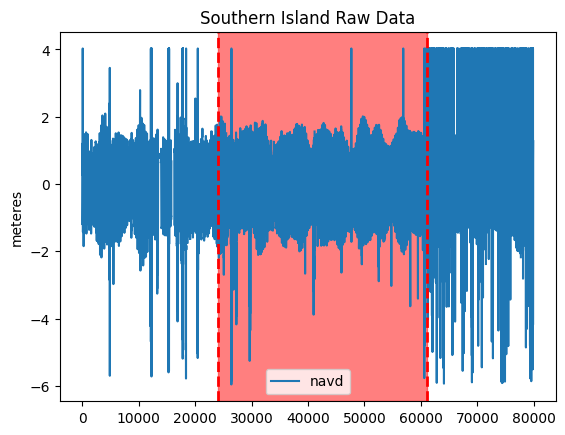

In [8]:
# plt.plot(hobs1-hobs2)
plt.plot(hobs1, label = 'navd')
# plt.plot(hobs2, label = 'mllw')
# plt.plot(hobs3, label = 'd2w')
plt.legend()
plt.ylabel("meteres");
plt.title("Southern Island Raw Data")
plt.axvline(24000, c = 'r', lw = 2, ls = '--')
plt.axvline(61000, c = 'r', lw = 2, ls = '--')
plt.axvspan(24000,61000, color = 'r', alpha = 0.5)

## Cleaning Hohonu Bath data (NAVD)

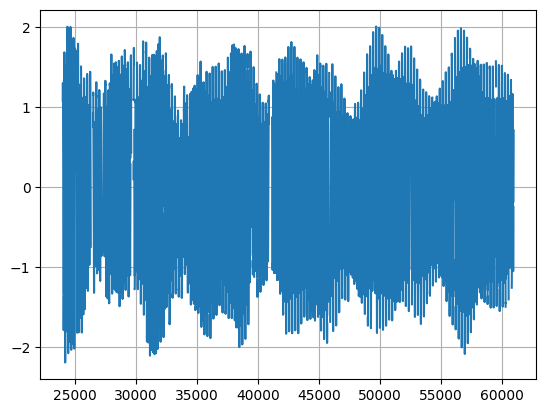

In [9]:
##### 
hobs11 = df.NAVD.copy()

##########
hobs11[25025:25100] = np.nan
hobs11[25065] = -2.0

hobs11[26300:26480] = np.nan
hobs11[26485:26495] = np.nan
hobs11[26390] = 1.3
hobs11[26430] = -0.9
hobs11[26785:26815] = np.nan

hobs11[27195:27325] = np.nan
hobs11[27250] = 1.2

hobs11[29620:29800] = np.nan
hobs11[29710] = 1.7
hobs11[29805:29815] = np.nan

hobs11[29895:29905] = np.nan

hobs11[32445:32460] = np.nan

hobs11[33440:33460] = np.nan

hobs11[34330] = 1.175

hobs11[37880:37900] = np.nan

hobs11[39430:39500] = np.nan
hobs11[39475] = -1.5

hobs11[39710:39740] = np.nan


hobs11[40920:41175] = np.nan
hobs11[41020] = 1.3
hobs11[41075] = -1.2
hobs11[40950] = -1.2
hobs11[41150] = 1.4

hobs11[41458:41480] = np.nan
hobs11[41520:41540] = np.nan
hobs11[41660:41670] = np.nan
hobs11[41685:41710] = np.nan

hobs11[45810:45850] = np.nan
hobs11[45860:45940] = np.nan

hobs11[47660:47690] = np.nan
hobs11[49020:49030] = np.nan
hobs11[49150:49170] = np.nan
hobs11[49510:49550] = np.nan

hobs11[51150:51160] = np.nan

hobs11[52470:52555] = np.nan
hobs11[52530] = -1.4

hobs11[52630:52650] = np.nan

hobs11[53500:53520] = np.nan

hobs11[54744:54785] = np.nan

hobs11[55090:55110] = np.nan

hobs11[56085:56120] = np.nan
hobs11[56130:56180] = np.nan
hobs11[56595:56605] = np.nan
hobs11[56855:56875] = np.nan

hobs11[58102:58150] = np.nan

hobs11[59465:59500] = np.nan
hobs11[59515:59540] = np.nan
hobs11[59555:59570] = np.nan

hobs11[60340:60360] = np.nan
hobs11[60460:60470] = np.nan
hobs11[60585:60630] = np.nan
hobs11[60810:60840] = np.nan
hobs11[60705:60720] = np.nan

##### SLICE PARAMETER #####

q = slice(24000,61000)

###########################

# plt.plot(htime[12000:13000], hobs11[12000:13000])
plt.plot(hobs11[q])
# plt.plot(htime[q], df['NAVD'][q])
# plt.plot(hobs11[q])
plt.grid()



In [10]:
hobs11 = pd.DataFrame(hobs11)
hobs1a = pd.DataFrame(hobs1)

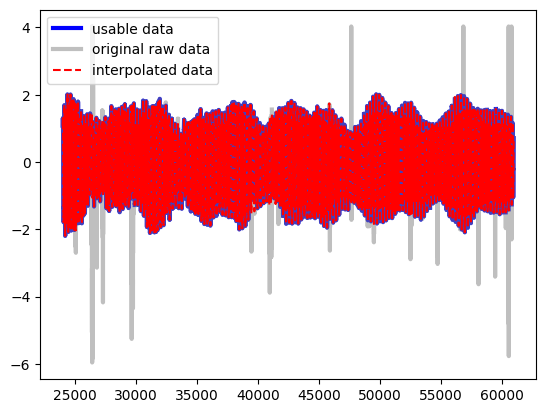

In [11]:
hobsint = hobs11.interpolate(method='polynomial', order=3)
# hobsint2 = hobs11[q].interpolate(method='polynomial', order=2)
plt.plot(hobs11[q], c = 'b', lw = 3, label = 'usable data')
plt.plot(hobs1a[q], c = '0.5', lw = 3, alpha = 0.5, label = 'original raw data')
plt.plot(hobsint[q], c= 'r', ls = '--', label = 'interpolated data')
plt.legend(loc = 'upper left')
plt.savefig("cleaning_example.png")

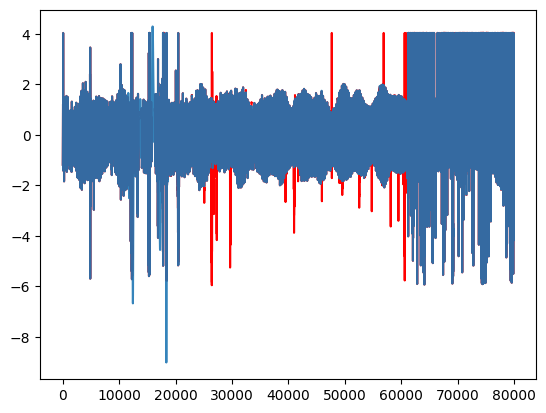

In [12]:
plt.plot(hobs1, c = 'r')
plt.plot(hobsint, alpha = 0.9)

## Saving CSV to use in calculating datums (From NOAA CO-OPS)

In [13]:
df = pd.DataFrame(hobsint[q].values, index = htime[q],  columns = ['WL'])

In [14]:
df.index = pd.to_datetime(df.index)

In [15]:
# Resample the DataFrame to 6-minute intervals and insert missing rows with empty values
resampled_df = df.resample('6T').asfreq()

In [16]:
# round everything to 3 decimals
wl= []
for obs in resampled_df.WL.values:
    wl.append(np.round(obs.data,3))
resampled_df.WL = wl
time_resamp = resampled_df.index.strftime('%m/%d/%Y %H:%M')
df = resampled_df.set_index(time_resamp)

In [17]:
df.head()

,WL
02/19/2023 01:12,1.082
02/19/2023 01:18,1.140
02/19/2023 01:24,1.161
02/19/2023 01:30,1.186
02/19/2023 01:36,1.222


In [18]:
# save final data as CSV
df.to_csv('StGeorgeSouthernIs_cleaned.csv', header = ['wl'])

Calculate datums using NOAA CO-OPS data calculator: https://access.co-ops.nos.noaa.gov/datumcalc/